In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import random
import csvread as csvread


In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 0
iterations = 10
testcam = True

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



model = NeuralNetwork() # we do not specify ``weights``, i.e. create untrained model
try:
    model.load_state_dict(torch.load('numbers_weights.pth', weights_only=True))
except:
    print("No saved model weights found, starting with a new model.")



Using mps device


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
def tryimg(iterations, model):
    for i in range(iterations):
        img, label = test_data[random.randint(0,len(test_data)-1)]
        model.eval()

        pred = model(img)
        pred = pred.argmax().item()
        plt.figure(figsize=(3,3))
        plt.imshow(img[0].squeeze(), cmap="gray")
        plt.show()
        print(f"Predicted class: {pred}")
        print(f"True class: {label}")

In [8]:
def camtest(model):
    img = csvread.outputtonet()
    pred = model(img).argmax().item()
    plt.figure(figsize=(3,3))
    plt.imshow(img[0].squeeze(), cmap="gray")
    plt.show()
    print(f"Predicted class: {pred}")

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

torch.save(model.state_dict(), 'numbers_weights.pth')

Done!


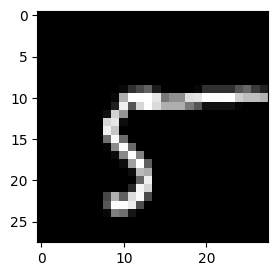

Predicted class: 5
True class: 5


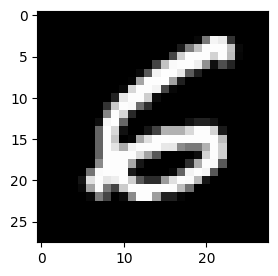

Predicted class: 6
True class: 6


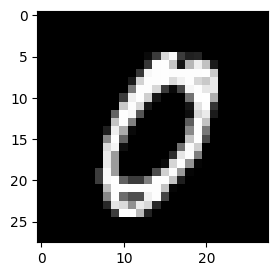

Predicted class: 0
True class: 0


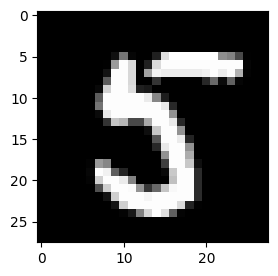

Predicted class: 5
True class: 5


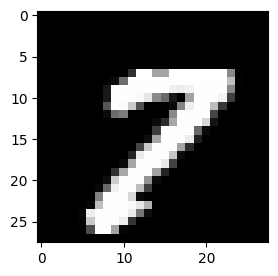

Predicted class: 7
True class: 7


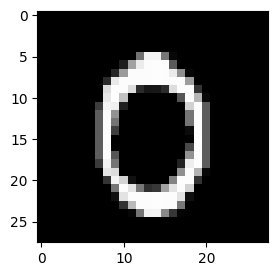

Predicted class: 0
True class: 0


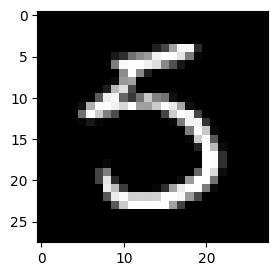

Predicted class: 5
True class: 5


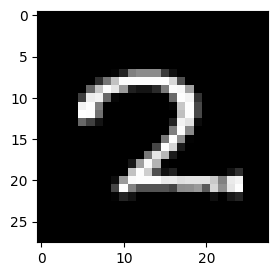

Predicted class: 2
True class: 2


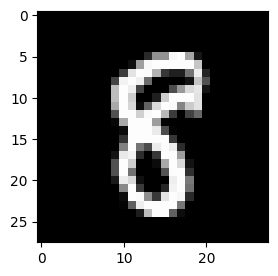

Predicted class: 8
True class: 8


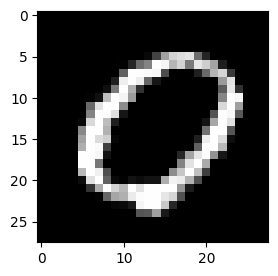

Predicted class: 0
True class: 0


In [10]:
tryimg(iterations, model)